## Imports


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Pre-Processing

In [91]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

def cleaned_options(option_type, df):
    # Convert Unix timestamps to datetime
    df['[QUOTE_DATETIME]'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
    df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

    # Load underlying price data for volatility computation
    underlying_prices = df[['[QUOTE_DATETIME]', '[UNDERLYING_LAST]']].drop_duplicates().set_index('[QUOTE_DATETIME]').sort_index()

    # Function to compute historical volatility
    def historical_volatility(series, window=20):
        return np.sqrt(252) * series.pct_change().rolling(window=window).std()

    # Compute 20-day historical volatility
    underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
    underlying_prices.dropna(inplace=True)

    # Merge historical volatility back into main dataframe
    df = df.merge(underlying_prices[['hist_vol_20d']], left_on='[QUOTE_DATETIME]', right_index=True, how='inner')

    # Columns to numeric conversion: choose columns based on option type
    if option_type == 'call':
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                        '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
    else:
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                        '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate mid-price based on option type
    if option_type == 'call':
        df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
    else:
        df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

    # Drop rows with missing essential data (dynamically chosen based on option type)
    essential_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
    if option_type == 'call':
        essential_cols.append('CALL_EQUI_PRICE')
    else:
        essential_cols.append('PUT_EQUI_PRICE')
    df.dropna(subset=essential_cols, inplace=True)

    # Prepare option data based on the option type
    if option_type == 'call':
        option_cols = ['[STRIKE]', '[C_BID]', '[C_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'CALL_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']
    else:
        option_cols = ['[STRIKE]', '[P_BID]', '[P_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'PUT_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']

    option_df = df[option_cols].copy()
    option_df.columns = col_rename

    # Normalize strike price and compute time to expiry in years
    option_df['strike_price'] = option_df['strike_price'] / 1000
    option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
    option_df.drop('days_to_expiry', axis=1, inplace=True)
    return option_df

calls_df = cleaned_options("call", df)
puts_df = cleaned_options("put", df)
print(calls_df.columns.tolist())
print(puts_df.columns.tolist())

['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'hist_volatility', 'equilibrium_price', 'time_to_expiry']
['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'hist_volatility', 'equilibrium_price', 'time_to_expiry']


## Underlying Processing

In [79]:
# 1) For calls
calls_close_df = (
    calls_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

# 2) For puts
puts_close_df = (
    puts_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

combined_df = pd.concat([calls_close_df, puts_close_df], ignore_index=True)
underlying = (
    puts_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

## Hyperparameters

In [ ]:
N_TIMESTEPS = 20
NUM_FEATURES = 4
BATCH_SIZE = 4096
EPOCHS = 60

## Rolling Window Logic

In [41]:
def build_rolling_sequences(
    df,
    date_col="date",
    input_cols=["underlying_price", "strike_price", "hist_volatility"],
    bid_col="best_bid",
    ask_col="best_ask",
    use_midpoint_target=True,     # If True, label = (best_bid + best_ask)/2
    target_col="equilibrium_price", 
    n_timesteps=20,
    train_ratio=0.8
):
    """
    1) Sort df by 'date_col'.
    2) For each row i from n_timesteps..end, builds a window [i-n_timesteps : i-1]
       of the columns in 'input_cols'.
    3) By default, label is midpoint of best_bid & best_ask at row i; 
       or specify 'target_col' if you prefer a single column as the label.
    4) Returns X_train, X_test, y_train, y_test with time-based splitting.
    
    X shape: (num_samples, n_timesteps, len(input_cols))
    y shape: (num_samples,)
    """
    # Sort by date to ensure chronological order
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    n_rows = len(df_sorted)
    
    X_seq = []
    y_seq = []
    
    # Build rolling windows
    for i in range(n_timesteps, n_rows):
        # Collect the last n_timesteps from each of the 'input_cols'
        window_data = []
        for col in input_cols:
            col_window = df_sorted.loc[i - n_timesteps : i - 1, col].values
            window_data.append(col_window)
        
        # Stack horizontally so shape is (n_timesteps, num_features)
        window_data = np.column_stack(window_data)
        
        # Create the label (either midpoint or a specific column)
        if use_midpoint_target:
            label_val = (
                df_sorted.loc[i, bid_col] +
                df_sorted.loc[i, ask_col]
            ) / 2
        else:
            label_val = df_sorted.loc[i, target_col]
        
        X_seq.append(window_data)
        y_seq.append(label_val)
    
    # Convert to numpy arrays
    X_seq = np.array(X_seq)  # (samples, n_timesteps, num_features)
    y_seq = np.array(y_seq)  # (samples,)

    # Time-based train-test split
    n_samples = len(X_seq)
    n_train = int(n_samples * train_ratio)
    
    X_train, X_test = X_seq[:n_train], X_seq[n_train:]
    y_train, y_test = y_seq[:n_train], y_seq[n_train:]
    
    print("Total samples:", n_samples)
    print("Train samples:", n_train, "Test samples:", n_samples - n_train)
    print("X shape:", X_seq.shape, "y shape:", y_seq.shape)
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_test :", X_test.shape,  "y_test :", y_test.shape)
    
    return X_train, X_test, y_train, y_test

## Prepare Test Split

In [92]:
padded = np.insert(underlying.close.values, 0, np.array([np.nan] * N_TIMESTEPS))
rolled = np.column_stack([np.roll(padded, i) for i in range(N_TIMESTEPS)])
rolled = rolled[~np.isnan(rolled).any(axis=1)]
rolled = np.column_stack((underlying.date.values[N_TIMESTEPS - 1:], rolled))
price_history = pd.DataFrame(data=rolled)
price_history.columns = ['date'] + [f"lag_{i}" for i in range(N_TIMESTEPS)]

calls_df, puts_df = calls_df.merge(price_history, on='date', how='inner'), puts_df.merge(price_history, on='date', how='inner')
calls_df, puts_df, = calls_df.drop(columns=['date']), puts_df.drop(columns=['date'])

X_call_train, X_call_test, y_call_train, y_call_test = train_test_split(calls_df.drop(['best_bid', 'best_ask'], axis=1).values,
                                                                        ((calls_df.best_bid + calls_df.best_ask) / 2).values,
                                                                        test_size=0.01, random_state=42)

X_put_train, X_put_test, y_put_train, y_put_test = train_test_split(puts_df.drop(['best_bid', 'best_ask'], axis=1).values,
                                                                    ((puts_df.best_bid + puts_df.best_ask) / 2).values,
                                                                    test_size=0.01, random_state=42)

call_X_train = [X_call_train[:, -N_TIMESTEPS:].reshape(X_call_train.shape[0], N_TIMESTEPS, 1), X_call_train[:, :4]]
call_X_test = [X_call_test[:, -N_TIMESTEPS:].reshape(X_call_test.shape[0], N_TIMESTEPS, 1), X_call_test[:, :4]]
put_X_train = [X_put_train[:, -N_TIMESTEPS:].reshape(X_put_train.shape[0], N_TIMESTEPS, 1), X_put_train[:, :4]]
put_X_test = [X_put_test[:, -N_TIMESTEPS:].reshape(X_put_test.shape[0], N_TIMESTEPS, 1), X_put_test[:, :4]]

## Scaling

In [94]:
# Create separate scalers for calls and puts
scaler_calls = StandardScaler()
scaler_puts = StandardScaler()

# Scale call X data
X_call_train_scaled = scaler_calls.fit_transform(X_call_train)
X_call_test_scaled = scaler_calls.transform(X_call_test)

# Scale put X data
X_put_train_scaled = scaler_puts.fit_transform(X_put_train)
X_put_test_scaled = scaler_puts.transform(X_put_test)

# Reshape the last N_TIMESTEPS columns for LSTM
call_X_train_scaled = [
    X_call_train_scaled[:, -N_TIMESTEPS:].reshape(X_call_train_scaled.shape[0], N_TIMESTEPS, 1),
    X_call_train_scaled[:, :4]
]
call_X_test_scaled = [
    X_call_test_scaled[:, -N_TIMESTEPS:].reshape(X_call_test_scaled.shape[0], N_TIMESTEPS, 1),
    X_call_test_scaled[:, :4]
]

put_X_train_scaled = [
    X_put_train_scaled[:, -N_TIMESTEPS:].reshape(X_put_train_scaled.shape[0], N_TIMESTEPS, 1),
    X_put_train_scaled[:, :4]
]
put_X_test_scaled = [
    X_put_test_scaled[:, -N_TIMESTEPS:].reshape(X_put_test_scaled.shape[0], N_TIMESTEPS, 1),
    X_put_test_scaled[:, :4]
]

## LSTM Model

In [ ]:
def create_multi_input_model(
    n_timesteps=20,
    n_lstm_features=1,   # each timestep has 1 feature: 'lag' value
    n_static_features=7, # the 7 static columns
    lstm_units=32,
    dense_layers=2,
    dense_units=64
):
    # Time series input
    time_input = Input(shape=(n_timesteps, n_lstm_features), name="time_input")
    x = LSTM(lstm_units, return_sequences=True)(time_input)
    x = LSTM(lstm_units, return_sequences=False)(x)  # final LSTM layer

    # Optionally add some dense layers right after the LSTM
    for _ in range(dense_layers):
        x = Dense(dense_units)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    # Static input
    static_input = Input(shape=(n_static_features,), name="static_input")
    
    # Concatenate both
    combined = Concatenate()([x, static_input])
    
    # More dense layers if desired
    for _ in range(dense_layers):
        combined = Dense(dense_units)(combined)
        combined = BatchNormalization()(combined)
        combined = LeakyReLU()(combined)
    
    # Final output
    output = Dense(1, activation='linear', name="price_output")(combined)

    model = Model(inputs=[time_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [105]:
print("X_call_train shape:", X_call_train.shape)

X_call_train shape: (1522624, 25)


## Training for Calls

In [ ]:
# Suppose X_call_train is (N, 25).
N = X_call_train.shape[0]

# The first 5 columns = static features
X_call_train_static = X_call_train[:, :5]  # shape => (N, 5)

# The last 20 columns = time series
X_call_train_lstm   = X_call_train[:, 5:].reshape(N, 20, 1)  # shape => (N, 20, 1)

# Do the same for X_call_test
N_test = X_call_test.shape[0]
X_call_test_static = X_call_test[:, :5]
X_call_test_lstm   = X_call_test[:, 5:].reshape(N_test, 20, 1)

call_model = create_multi_input_model(
    n_timesteps=N_TIMESTEPS,
    n_lstm_features=1,
    n_static_features=5,
    lstm_units=32,
    dense_layers=2,
    dense_units=64
)
call_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

call_history = call_model.fit(
    x=[X_call_train_lstm, X_call_train_static],  # multi-input
    y=y_call_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.01,
    callbacks=[reduce_lr, TensorBoard(log_dir='./logs')],
    verbose=1
)

call_model.save('call-lstm-v1.h5')

Epoch 1/60
737/737 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - loss: 490.5920 - val_loss: 79.1581 - learning_rate: 0.0100
Epoch 2/60
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - loss: 3.4978 - val_loss: 945.7781 - learning_rate: 0.0100
Epoch 3/60
736/737 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.8191
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
737/737 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - loss: 3.8188 - val_loss: 979.3372 - learning_rate: 0.0100
Epoch 4/60
737/737 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - loss: 3.1793 - val_loss: 12.4149 - learning_rate: 0.0050
Epoch 5/60
737/737 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - loss: 3.5601 - val_loss: 11.4225 - learning_rate: 0.0050
Epoch 6/60
737/737 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - loss: 3.3718 - val_loss: 44.4039 - learning_rate: 0.0050
Epoch 7/60
548/737 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 2.8395

KeyboardInterrupt: 

## Training for Puts

In [ ]:
# 1) Split your X_put_train into time-series vs. static:
N_put_train = X_put_train.shape[0]

# The first 5 columns = static features
X_put_train_static = X_put_train[:, :5]  # shape => (N_put_train, 5)

# The last 20 columns = time series
X_put_train_lstm   = X_put_train[:, 5:].reshape(N_put_train, 20, 1)  # shape => (N_put_train, 20, 1)

# 2) Same splitting for X_put_test
N_put_test = X_put_test.shape[0]
X_put_test_static = X_put_test[:, :5]
X_put_test_lstm   = X_put_test[:, 5:].reshape(N_put_test, 20, 1)

# 3) Build & compile a multi-input LSTM model for puts
put_model = create_multi_input_model(
    n_timesteps=20,
    n_lstm_features=1,
    n_static_features=5,
    lstm_units=32,
    dense_layers=2,
    dense_units=64
)
put_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# 4) Train
put_history = put_model.fit(
    x=[X_put_train_lstm, X_put_train_static],  # multi-input
    y=y_put_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.01,
    callbacks=[reduce_lr, TensorBoard(log_dir='./logs')],
    verbose=1
)

# 5) Save
put_model.save('put-lstm-v1.h5')

NameError: name 'reduce_lr' is not defined

## Test Models

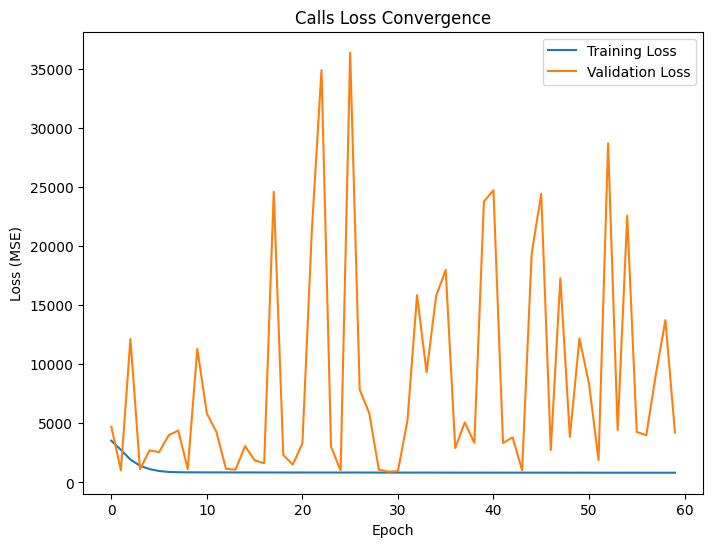

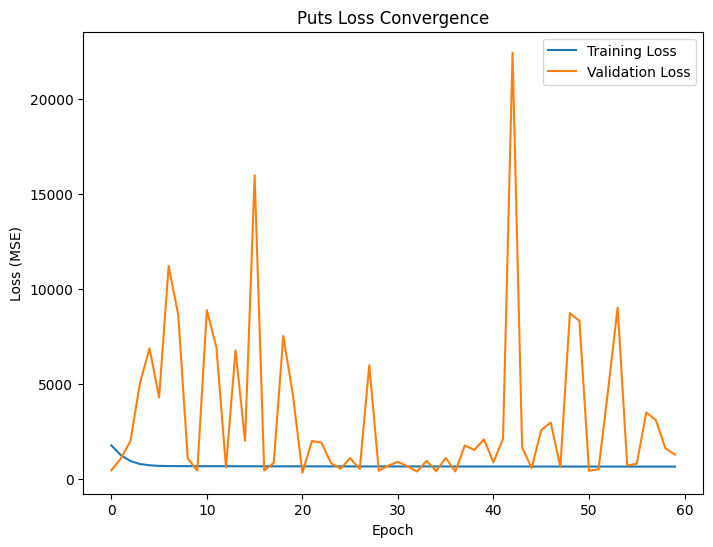

In [ ]:
def plot_loss_convergence(history, title):
    """
    Plots training vs validation loss over epochs.
    """
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()

plot_loss_convergence(call_history, "Calls Loss Convergence")
plot_loss_convergence(put_history, "Puts Loss Convergence")